In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive.zip"
data_path = "/content/drive/MyDrive/FashionMNIST"

# Create directory if not exists
os.makedirs(data_path, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

print("✅ Dataset extracted successfully")


✅ Dataset extracted successfully


In [ ]:
data_path = "/content/drive/MyDrive/FashionMNIST"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root=data_path,
    train=True,
    transform=transform,
    download=True   # dataset already in Drive
)

dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 5.35MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.94MB/s]


In [ ]:
latent_dim = 128   # 🔼 increased noise vector size
lr = 0.00002
num_epochs = 50


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

# ✅ RMSprop optimizer (task requirement)
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)


In [ ]:
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_imgs, _ in dataloader:

        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -------- Train Discriminator --------
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -------- Train Generator --------
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/50] | D Loss: 0.6132 | G Loss: 0.7085
Epoch [2/50] | D Loss: 0.5625 | G Loss: 0.7662
Epoch [3/50] | D Loss: 0.6305 | G Loss: 0.7821
Epoch [4/50] | D Loss: 0.6003 | G Loss: 0.8238
Epoch [5/50] | D Loss: 0.6283 | G Loss: 0.7415
Epoch [6/50] | D Loss: 0.6487 | G Loss: 0.6875
Epoch [7/50] | D Loss: 0.6316 | G Loss: 0.7741
Epoch [8/50] | D Loss: 0.6892 | G Loss: 0.7180
Epoch [9/50] | D Loss: 0.6369 | G Loss: 0.8999
Epoch [10/50] | D Loss: 0.6426 | G Loss: 0.8772
Epoch [11/50] | D Loss: 0.6400 | G Loss: 0.8108
Epoch [12/50] | D Loss: 0.6633 | G Loss: 0.7376
Epoch [13/50] | D Loss: 0.6295 | G Loss: 0.8187
Epoch [14/50] | D Loss: 0.6178 | G Loss: 1.0693
Epoch [15/50] | D Loss: 0.6776 | G Loss: 0.9401
Epoch [16/50] | D Loss: 0.6590 | G Loss: 0.7924
Epoch [17/50] | D Loss: 0.6193 | G Loss: 0.7853
Epoch [18/50] | D Loss: 0.6532 | G Loss: 0.7692
Epoch [19/50] | D Loss: 0.6684 | G Loss: 0.7904
Epoch [20/50] | D Loss: 0.6636 | G Loss: 0.6475
Epoch [21/50] | D Loss: 0.5884 | G Loss: 0.9512
E

In [ ]:
checkpoint_path = "/content/drive/MyDrive/gan_fashion_checkpoint.pth"


In [ ]:
torch.save({
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'g_losses': g_losses,
    'd_losses': d_losses
}, checkpoint_path)

print("✅ Checkpoint saved successfully")


✅ Checkpoint saved successfully


In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)

generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

start_epoch = checkpoint['epoch'] + 1

g_losses = checkpoint['g_losses']
d_losses = checkpoint['d_losses']

print(f"✅ Resuming training from epoch {start_epoch}")


✅ Resuming training from epoch 50


In [ ]:
num_epochs_new = 100   # total epochs you want

for epoch in range(start_epoch, num_epochs_new):
    for real_imgs, _ in dataloader:

        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Label smoothing (recommended)
        valid = torch.ones(batch_size, 1).to(device) * 0.9
        fake = torch.zeros(batch_size, 1).to(device)

        # ----- Train Discriminator -----
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), valid)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ----- Train Generator -----
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs_new}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [51/100] | D Loss: 0.6556 | G Loss: 0.7883
Epoch [52/100] | D Loss: 0.6703 | G Loss: 0.8897
Epoch [53/100] | D Loss: 0.6870 | G Loss: 0.7549
Epoch [54/100] | D Loss: 0.6644 | G Loss: 0.7781
Epoch [55/100] | D Loss: 0.6949 | G Loss: 0.7678
Epoch [56/100] | D Loss: 0.7097 | G Loss: 0.7328
Epoch [57/100] | D Loss: 0.6802 | G Loss: 0.8965
Epoch [58/100] | D Loss: 0.6589 | G Loss: 0.8550
Epoch [59/100] | D Loss: 0.6889 | G Loss: 0.8146
Epoch [60/100] | D Loss: 0.6893 | G Loss: 0.7420
Epoch [61/100] | D Loss: 0.6829 | G Loss: 0.8187
Epoch [62/100] | D Loss: 0.6932 | G Loss: 0.7885
Epoch [63/100] | D Loss: 0.6601 | G Loss: 0.8696
Epoch [64/100] | D Loss: 0.7021 | G Loss: 0.7793
Epoch [65/100] | D Loss: 0.7004 | G Loss: 0.8027
Epoch [66/100] | D Loss: 0.6761 | G Loss: 0.8618
Epoch [67/100] | D Loss: 0.6867 | G Loss: 0.8691
Epoch [68/100] | D Loss: 0.6791 | G Loss: 0.8754
Epoch [69/100] | D Loss: 0.6884 | G Loss: 0.7933
Epoch [70/100] | D Loss: 0.6977 | G Loss: 0.9575
Epoch [71/100] | D L

In [ ]:
torch.save({
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'g_losses': g_losses,
    'd_losses': d_losses
}, checkpoint_path)

print("✅ Updated checkpoint saved")


✅ Updated checkpoint saved


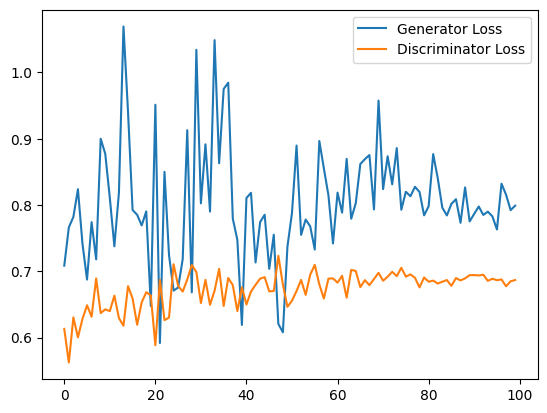

In [ ]:
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.legend()
plt.show()


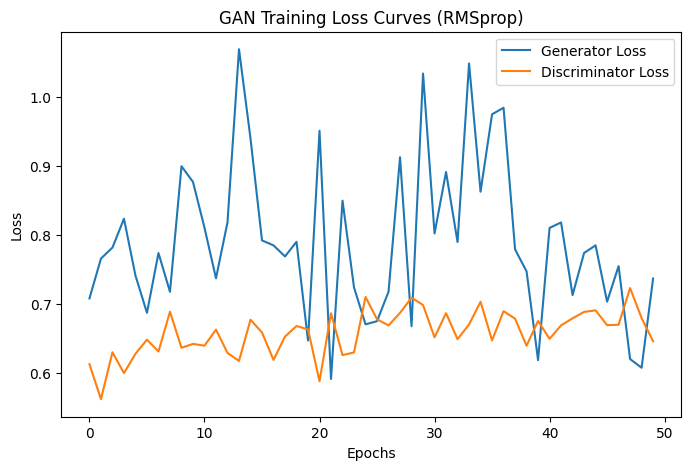

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves (RMSprop)")
plt.legend()
plt.show()


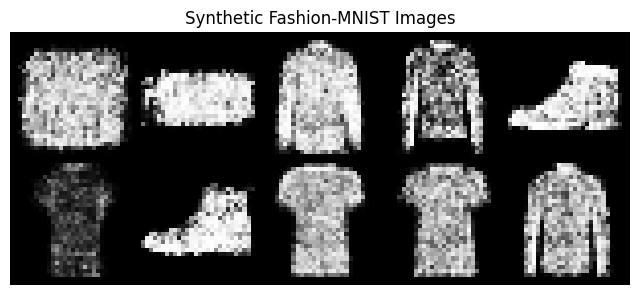

In [ ]:
generator.eval()

with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    generated_imgs = generator(z).cpu()

grid = torchvision.utils.make_grid(generated_imgs, nrow=5, normalize=True)

plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title("Synthetic Fashion-MNIST Images")
plt.show()
